In [103]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from PIL import Image
import itertools
%matplotlib inline

In [104]:
from functions import * #импортируем все функции

import os #функции для взаимодействия с операционной системой (например, с файлами)

from tqdm import tqdm #Этот оператор импортирует класс tqdm из модуля tqdm.
#tqdm - библиотека, которая предоставляет индикатор прогресса для итераций в циклах.
#Он позволяет визуально отслеживать прогресс выполнения длительных операций

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [106]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from glob import glob

# Новый код

In [107]:
os.getcwd()

'/home/kravchenko.artem/Projects/Diplomas/Danya/ejection-fraction'

In [108]:
import pickle
import torch

# Функция для загрузки и предобработки данных
def load_data():
    # Загрузка данных из файлов .pkl
    with open("../../Data/dumped/X_train_fraction_train_2.pkl", "rb") as f:
        X_train = pickle.load(f)
    with open("../../Data/dumped/y_train_fraction_train_2.pkl", "rb") as f:
        y_train = pickle.load(f)
    with open("../../Data/dumped/X_test_fraction_test_1.pkl", "rb") as f:
        X_test = pickle.load(f)
    with open("../../Data/dumped/y_test_fraction_test_1.pkl", "rb") as f:
        y_test = pickle.load(f)


    print("Original shapes:")
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)

    # Приведение данных к типу NumPy
    X_train = np.array(X_train, dtype=np.float32)  # Приводим к типу float32
    X_test = np.array(X_test, dtype=np.float32)    # Приводим к типу float32

    # Убедимся, что размеры верные и преобразуем в нужный формат
    #X_train = X_train.reshape(-1, 8, 5000)  # Трансформируем в (кол-во образцов, 8, 5000)
    #X_test = X_test.reshape(-1, 8, 5000)

    # Преобразуем y_train и y_test в нужный формат
    Y_train = np.array(y_train[0], dtype=np.int64)  # Приводим к типу int64
    Y_test = np.array(y_test[0], dtype=np.int64)    # Приводим к типу int64

    # Преобразуем данные в тензор
    Y_train = torch.tensor(Y_train)
    Y_test = torch.tensor(Y_test)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)

    return X_train, Y_train, X_test, Y_test

# Загрузка данных
X_train, Y_train, X_test, Y_test = load_data()

# Проверка размерностей
print("Processed shapes:")
print("X_train shape:", X_train.shape)  # Ожидается (N, 8, 5000)
print("Y_train shape:", Y_train.shape)    # Ожидается (N,)

Original shapes:
X_train shape: (908, 8, 5000)
y_train shape: (2, 908)
Processed shapes:
X_train shape: torch.Size([908, 8, 5000])
Y_train shape: torch.Size([908])


In [109]:
print("X_test shape:", X_test.shape)  # Ожидается (N, 8, 5000)
print("Y_test shape:", Y_test.shape)

X_test shape: torch.Size([5398, 8, 5000])
Y_test shape: torch.Size([5398])


In [110]:
# Извлекаем данные из соответствующих каналов
DI = X_train[:, 0, :]  # 1 канал
DII = X_train[:, 1, :]  # 2 канал
V1 = X_train[:, 2, :]  # 3 канал
V2 = X_train[:, 3, :]  # 4 канал
V3 = X_train[:, 4, :]  # 5 канал
V4 = X_train[:, 5, :]  # 6 канал
V5 = X_train[:, 6, :]  # 7 канал
V6 = X_train[:, 7, :]  # 8 канал

# Применение формул для вычисления x, y и z
x = -(0.156 * DI - 0.01 * DII - 0.172 * V1 - 0.074 * V2 +
      0.122 * V3 + 0.231 * V4 + 0.239 * V5 + 0.194 * V6)

y = (- 0.227 * DI + 0.887 * DII + 0.057 * V1 - 0.019 * V2 -
      0.106 * V3 - 0.022 * V4 + 0.041 * V5 + 0.048 * V6)

z = -(0.022 * DI + 0.102 * DII - 0.229 * V1 - 0.31 * V2 -
      0.246 * V3 - 0.063 * V4 + 0.055 * V5 + 0.108 * V6)

# Добавление новых каналов в X_train
X_train = torch.cat((X_train, x.unsqueeze(1), y.unsqueeze(1), z.unsqueeze(1)), dim=1)

X_train = X_train[:, -3:, :]# Получаем последние три канала

#X_train = X_train.permute(0, 2, 1)
# Проверка размерностей
print("Updated X_train shape:", X_train.shape)

Updated X_train shape: torch.Size([908, 3, 5000])


In [111]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter

class PointCloudData(Dataset):
    def __init__(self, X, Y, transform=None):
        # Храним только последние три канала (x, y, z) из X
        self.X = X
        self.Y = Y  # Тензор меток классов (N, кол-во классов)
        self.transform = transform
        
        # Подсчет образцов каждого класса
        self.class_counts = self._count_classes()

    def _count_classes(self):
        # Используем Counter для подсчета меток классов
        return dict(Counter(self.Y.numpy()))  # Преобразуем тензор меток в массив и считаем

    def __len__(self):
        return self.X.shape[0]  # Количество образцов

    def __getitem__(self, idx):
        # Убедимся, что индекс не выходит за границы
        if idx >= len(self.X):
            raise IndexError(f"Index {idx} is out of bounds for dataset with size {len(self.X)}")

        point_cloud = self.X[idx]
        target = int(self.Y[idx])  # массив меток классов

        if self.transform:
            point_cloud = self.transform(point_cloud.numpy())  # Применяем нормализацию

        return {
            'pointcloud': point_cloud,
            'category': target,
        }

In [112]:
train_transforms = transforms.Compose([
    Normalize(),
    PointSampler_weighted(5000),
    RandomNoise(std=0.001),
    ToTensor()
])

In [113]:
# Создаем объект датасета
train_ds = PointCloudData(X_train, Y_train, transform =None)
# Создаем загрузчик данных
BATCH_SIZE = 64  # размер батча
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(train_ds)
print(train_loader)
train_ds.class_counts

{0: 454, 1: 454}

In [114]:
print(Y_train)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Обучение

In [115]:
# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху равняется', iterations_per_epoch)

Число градиентных спусков за 1 эпоху равняется 14


In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pointnet = PointNet()
pointnet.to(device)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [117]:
#pip install mlflow

In [118]:
# Инициализация MLflow
import mlflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("VECG_POINTNET_Classification")

<Experiment: artifact_location='mlflow-artifacts:/123889227955261912', creation_time=1738156248020, experiment_id='123889227955261912', last_update_time=1738156248020, lifecycle_stage='active', name='VECG_POINTNET_Classification', tags={}>

In [119]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: torch.Size([908, 3, 5000])
Y_train shape: torch.Size([908])


# Функции оценки

In [120]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha=0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [121]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [122]:
    
def weighted_avg_f1(output, labels):
    """Функция расчета weighted avg F1-меры"""
    # Преобразование списков в массивы numpy
    output = np.array(output)
    labels = np.array(labels)

    # Создание тензоров PyTorch
    output = torch.tensor(output)
    labels = torch.tensor(labels)

    predictions = torch.argmax(output, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    weighted_f1 = f1_score(labels, predictions, average='weighted')
    weighted_f1 = np.nan_to_num(weighted_f1, nan=0.0)  # Замена NaN на 0 при делении на 0

    return weighted_f1

In [123]:
def accuracy(output,labels):
    """Функция расчета accuracy"""
    # Преобразование списков в массивы numpy
    output = np.array(output)
    labels = np.array(labels)

    # Создание тензоров PyTorch
    output = torch.tensor(output)
    labels = torch.tensor(labels)

    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [124]:
def evaluate_model(model, data_loader):
    """Функция для логирования артефактов в MLflow"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
 
            outputs, _, _ = model(inputs) #inputs.transpose(1,2)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Сохранение отчета в текстовый файл
    report = classification_report(true_labels, predicted_labels)
    output_file = "classification_report.txt"
    with open(output_file, "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report.txt")
    os.remove("classification_report.txt")
        
    # Save confusion matrix as CSV artifact
    df = pd.DataFrame(cm)
    new_columns = [f"predicted class {i}" for i in range(df.shape[1])]

    # Установка новых названий столбцов
    df.columns = new_columns

    # Добавление индексов
    df.insert(0, "real\pred", [f"real class {i}" for i in range(df.shape[0])])

    # Сохранение измененной таблицы 
    df.to_csv("confusion_matrix.csv", index=False)
    mlflow.log_artifact("confusion_matrix.csv")
    os.remove("confusion_matrix.csv")

In [125]:
def train_pointnet(model_pointnet, dataloader_train, batch_size, 
                     name_save, start_weight, 
                     name_experiment=None, lr=0.00025, epochs=8,
                     scheduler=True, scheduler_step_size=10, dataset_name=None,
                     f_sampling=700, seed=42, n_points=512,
                     normalize='Centering and max value scaling', gamma=0.5, noise_std=0):
    """Обучение классификационной сети

    Args:
        model_pointnet: Класс модели pytorch

        dataloader_train: Обучающий даталоудер

        batch_size: Размер одного батча

        name_save: Имя модели для сохранения в папку models

        start_weight: Если указать веса, то сеть будет в режиме fine tune. Defaults to None.

        name_experiment:  Имя эксперимента для MLflow. Нужно при mlflow_tracking=True. Defaults to None.
        
        lr: Скорость обучения. Defaults to lr=0.00025.

        epochs: Число эпох обучения. Defaults to 100.

        scheduler (bool): Включение/выключение lr шедулера. Defaults to True.

        scheduler_step_size (int): Шаг шедулера при scheduler=True. Defaults to 10.

        dataset_name: Имя датасета для логирования в MLflow. Defaults to None.

        seed (int): Seed рандома. Defaults to 42.
        
        normalize: Вид нормализации

        gamma: Величина коэффициента lr шедулера 

        noise_std: Величина std шума на трейне

    """
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    if dataset_name != None:
        dataset_name = dataset_name.split('\\')[-1]

    directory_save = ".\\..\\models"

    if not os.path.exists(directory_save):
        os.makedirs(directory_save)
    
    if name_experiment == None:
        name_experiment = name_save
    with mlflow.start_run(run_name=name_experiment) as run:
        
        model = model_pointnet()
        mlflow.log_param("Model", 'PointNet')
        if start_weight != None:
            model.load_state_dict(torch.load(start_weight, map_location=torch.device('cpu')))

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        if scheduler:
            gamma_val = gamma
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                                        step_size=scheduler_step_size,
                                                        gamma=gamma_val)
        model = model.to(device)
        
        mlflow.log_param("Normalize", normalize)
        mlflow.log_param("Training random noise std", noise_std)
        mlflow.log_param("Input shape", f'torch.Size([batch_size, {n_points}, 3])')
        mlflow.log_param("F sampling ECG", f_sampling)
        mlflow.log_param("Points samping", n_points)
        if scheduler:
            mlflow.log_param("scheduler", 'On')
            mlflow.log_param("scheduler_step_size", scheduler_step_size)
            mlflow.log_param("scheduler_gamma", gamma_val)
        else:
            mlflow.log_param("scheduler", 'Off')

        mlflow.log_param("lr", lr)
        mlflow.log_param("optimizer", 'Adam')
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("loss", 'NLLLoss + 0.0001*Loss_reg')
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("dataset", dataset_name)
        mlflow.log_param("seed", seed)
        if start_weight != None:
            mlflow.log_param("Fine-tuning", True)
        else:
            mlflow.log_param("Fine-tuning", False)

        max_epoch_f1_train = 0
        for epoch in range(epochs): 
            model.train()
            running_loss = 0.0
            all_outputs = []
            all_targets = []
            for i, data in enumerate(dataloader_train, 0):
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                optimizer.zero_grad()
                print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Inputs shape: {inputs.shape}, Labels shape: {labels.shape}')
                inputs = inputs.permute(0, 1, 2)
                outputs, m3x3, m64x64 = model(inputs)
                
                loss = pointnetloss(outputs, labels, m3x3, m64x64)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                all_outputs.extend(outputs.cpu().detach().numpy())
                all_targets.extend(labels.cpu().numpy())

                
            train_epoch_loss = running_loss / len(dataloader_train)
            train_epoch_acc = accuracy(all_outputs, all_targets)
            train_epoch_f1 = weighted_avg_f1(all_outputs, all_targets)

            mlflow.log_metric("train_epoch_accuracy", train_epoch_acc, step=(epoch+1))
            mlflow.log_metric("train_epoch_loss", train_epoch_loss, step=(epoch+1))
            mlflow.log_metric("train_epoch_f1", train_epoch_f1, step=(epoch+1))


            if scheduler:
                lr_scheduler.step()

            # Вывод значения функции потерь на каждой 5 эпохе
            #if ((epoch+1) % 5 == 0) or epoch==0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_epoch_loss:.4f},'
                  f' Train Aсс: {train_epoch_acc:.4f}')


            if epoch >= 1 and train_epoch_f1 > max_epoch_f1_train:
                max_epoch_f1_train = train_epoch_f1
                acc_model = train_epoch_acc
                model_to_save = model
                epoch_best = epoch + 1
                name_save_model = directory_save + '\\' + name_save +'.pth'
                torch.save(model_to_save.state_dict(), name_save_model)
                evaluate_model(model=model, data_loader=dataloader_train)
            
        print('Обучение завершено')
        print(f'Сохранена модель {name_save_model} с лучшим weighted avg f1 на train = {max_epoch_f1_train}')  
        print('Accuracy данной модели равно', acc_model) 

        mlflow.log_metric("max f1 saved model", max_epoch_f1_train)
        mlflow.log_metric("accuracy of model", acc_model)
        mlflow.log_metric("epoch of save", epoch_best)

        mlflow.log_artifact(name_save_model)
        #mlflow.log_artifact('model.py')



###########################################

In [126]:
train_pointnet(
    model_pointnet=PointNet,
    dataloader_train=train_loader,
    batch_size=BATCH_SIZE,
    name_save='pointnet_weights_firstNetwork_FV',
    start_weight= None,
    name_experiment='train first Network_fv',
    lr=0.00025,
    epochs=8,
    scheduler=42,
    scheduler_step_size=10,
    dataset_name=None,
    f_sampling=700,
    seed=42,
    normalize='Centering and max value scaling',
    gamma=0.5,
    noise_std=0
)

Epoch: 1, Batch: 1, Inputs shape: torch.Size([64, 3, 5000]), Labels shape: torch.Size([64])
Epoch: 1, Batch: 2, Inputs shape: torch.Size([64, 3, 5000]), Labels shape: torch.Size([64])
Epoch: 1, Batch: 3, Inputs shape: torch.Size([64, 3, 5000]), Labels shape: torch.Size([64])
Epoch: 1, Batch: 4, Inputs shape: torch.Size([64, 3, 5000]), Labels shape: torch.Size([64])
Epoch: 1, Batch: 5, Inputs shape: torch.Size([64, 3, 5000]), Labels shape: torch.Size([64])
Epoch: 1, Batch: 6, Inputs shape: torch.Size([64, 3, 5000]), Labels shape: torch.Size([64])
Epoch: 1, Batch: 7, Inputs shape: torch.Size([64, 3, 5000]), Labels shape: torch.Size([64])
Epoch: 1, Batch: 8, Inputs shape: torch.Size([64, 3, 5000]), Labels shape: torch.Size([64])
Epoch: 1, Batch: 9, Inputs shape: torch.Size([64, 3, 5000]), Labels shape: torch.Size([64])
Epoch: 1, Batch: 10, Inputs shape: torch.Size([64, 3, 5000]), Labels shape: torch.Size([64])
Epoch: 1, Batch: 11, Inputs shape: torch.Size([64, 3, 5000]), Labels shape: tor

# Тест

In [127]:
print("X_test shape:", X_test.shape)  # Ожидается (N, 8, 5000)
print("Y_test shape:", Y_test.shape)    # Ожидается (N,)

X_test shape: torch.Size([5398, 8, 5000])
Y_test shape: torch.Size([5398])


In [128]:
# Извлекаем данные из соответствующих каналов
DI = X_test[:, 0, :]  # 1 канал
DII = X_test[:, 1, :]  # 2 канал
V1 = X_test[:, 2, :]  # 3 канал
V2 = X_test[:, 3, :]  # 4 канал
V3 = X_test[:, 4, :]  # 5 канал
V4 = X_test[:, 5, :]  # 6 канал
V5 = X_test[:, 6, :]  # 7 канал
V6 = X_test[:, 7, :]  # 8 канал

# Применение формул для вычисления x, y и z
x = -(0.156 * DI - 0.01 * DII - 0.172 * V1 - 0.074 * V2 +
      0.122 * V3 + 0.231 * V4 + 0.239 * V5 + 0.194 * V6)

y = (- 0.227 * DI + 0.887 * DII + 0.057 * V1 - 0.019 * V2 -
      0.106 * V3 - 0.022 * V4 + 0.041 * V5 + 0.048 * V6)

z = -(0.022 * DI + 0.102 * DII - 0.229 * V1 - 0.31 * V2 -
      0.246 * V3 - 0.063 * V4 + 0.055 * V5 + 0.108 * V6)

# Добавление новых каналов в X_test
X_test = torch.cat((X_test, x.unsqueeze(1), y.unsqueeze(1), z.unsqueeze(1)), dim=1)

X_test = X_test[:, -3:, :]# Получаем последние три канала

#X_train = X_test.permute(0, 2, 1)
# Проверка размерностей
print("Updated X_test shape:", X_test.shape)

Updated X_test shape: torch.Size([5398, 3, 5000])


In [129]:
test_transforms = transforms.Compose([
                    Normalize(),
                    PointSampler_weighted(5000),
                    ToTensor()
                    ])
test_ds = PointCloudData(X_test, Y_test, transform=None)
print(test_ds)
test_loader = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, drop_last=False)
print(test_loader)

In [130]:
import json
pointnet = PointNet()
# Загрузка сохраненных весов модели
pointnet.load_state_dict(torch.load(".\\..\\models\\pointnet_weights_firstNetwork_FV.pth"))

with open("../../Data/dumped/test_itoname_test_1.json") as f:
    itoname_test = json.load(f)

pointnet.eval().to('cpu')
all_preds = []
all_labels = []
# Создание списка с именами файлов
filenames = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs) #inputs.transpose(1,2)
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        filenames.append(itoname_test[str(i)])

# Сохранение в файл Excel
#results_df.to_excel('C:\\Users\\acer\\фв\\patient_classes.xlsx', index=False)

/tmp/ipykernel_728043/1127062490.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pointnet.load_state_dict(torch.load(".\\..\\models\\pointnet_weights_firstNetwork_FV.pth

In [131]:
results_df = pd.DataFrame({
    'Filename': filenames,
    'Class': all_preds,
    "Labels": all_labels
})

# Сохранение в файл Excel
results_df.to_csv('./train_2_test_1.csv', index=False)

In [132]:
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.metrics import recall_score, accuracy_score, precision_score
from clearml import Task, Logger

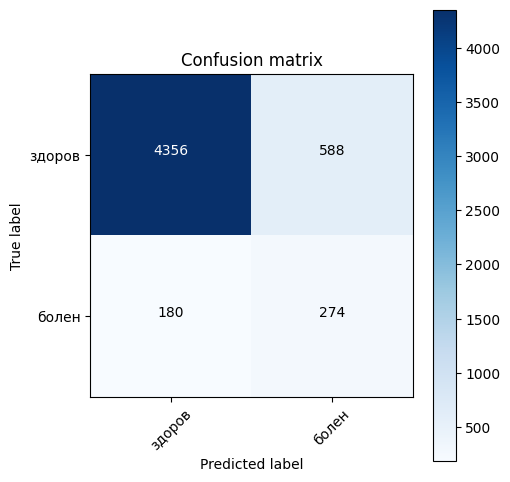

In [133]:
cm = confusion_matrix(all_labels, all_preds)
classes=['здоров','болен']
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, classes, normalize=False)

In [134]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      4944
           1       0.32      0.60      0.42       454

    accuracy                           0.86      5398
   macro avg       0.64      0.74      0.67      5398
weighted avg       0.91      0.86      0.88      5398

